In [1]:
# 오토글루온 설치
# conda create -n autogluon python=3.11 -y
# conda activate autogluon
# conda install ipython ipykernel

# python -m ipykernel install --user --name autogluon --display-name "autogluon"


# pip install -U pip
# pip install -U setuptools wheel
# pip install autogluon --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
# !pip install xgboost scikit-learn

In [3]:
import pandas as pd
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 대안데이터 불러오기
alter_raw = pd.DataFrame()

# 대안데이터 7월~11월 합치기
for i in range(7,12):
    data = pd.read_csv(f'../alternative_data/대안{i}.csv', encoding='cp949')
    alter_raw = pd.concat([alter_raw, data], axis=0)

alter_raw.shape

(50880, 143)

In [4]:
alter_data = copy.deepcopy(alter_raw)
alter_data.head()

,행정동코드,자치구,행정동,성별,연령대,총인구수,1인가구수,야간상주지 변경 미추정 인구 수,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 25%",...,배달_브랜드 서비스 사용 미추정 인구수,배달_브랜드 서비스 사용일수,"배달_브랜드 서비스 사용일수: 4분위수, 25%","배달_브랜드 서비스 사용일수: 4분위수, 50%","배달_브랜드 서비스 사용일수: 4분위수, 75%",배달_식재료 서비스 사용 미추정 인구수,배달_식재료 서비스 사용일수,"배달_식재료 서비스 사용일수: 4분위수, 25%","배달_식재료 서비스 사용일수: 4분위수, 50%","배달_식재료 서비스 사용일수: 4분위수, 75%"
0,1101053,종로구,사직동,1,20,206,64,0,2.5,2,...,181,3.5,1.7,3.3,6.7,204,1.7,1.7,1.7,1.7
1,1101053,종로구,사직동,1,25,341,115,0,2.1,1,...,285,2.8,1.7,1.7,3.3,338,1.7,1.7,1.7,1.7
2,1101053,종로구,사직동,1,30,402,132,0,1.9,1,...,348,3.3,1.7,1.7,5.0,396,1.7,1.7,1.7,1.7
3,1101053,종로구,사직동,1,35,408,125,0,1.9,1,...,344,3.2,1.7,3.3,3.3,400,1.7,1.7,1.7,1.7
4,1101053,종로구,사직동,1,40,399,99,0,1.7,1,...,355,3.0,1.7,1.7,5.0,389,1.7,1.7,1.7,1.7


In [5]:
# 사용하지 않을 컬럼 제거
words_to_drop = ['행정동코드','자치구','행정동','1인가구수', '4분위수',
                 '출근', '근무시간', '카카오톡','통화','문자','이동','집 추정','미추정','인구']

pattern = '|'.join(words_to_drop)
alter_data_clean = alter_data.loc[:, ~alter_data.columns.str.contains(pattern)]
alter_data_clean.head()

,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,SNS 사용횟수,데이터 사용량,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수
0,1,20,2.5,2.5,0.0,5944.4,6.74,0.0,21.4,56.8,141.3,123.5,56.6,0.3,-0.2,11.0,3.5,1.7
1,1,25,2.1,2.2,2.6,7777.8,10.85,0.2,19.8,41.3,187.9,174.5,56.0,0.2,-0.2,13.6,2.8,1.7
2,1,30,1.9,1.8,2.8,5854.2,7.96,0.2,17.1,34.0,188.9,181.4,55.9,0.2,-0.3,13.7,3.3,1.7
3,1,35,1.9,1.7,1.9,6286.7,8.82,0.1,13.6,33.2,184.8,189.6,54.8,0.1,-0.3,13.8,3.2,1.7
4,1,40,1.7,1.7,2.8,6098.0,6.53,0.1,11.2,22.5,189.8,199.2,55.2,0.0,-0.3,14.3,3.0,1.7


In [6]:
# alter_data_clean을 복사본으로 생성
alter_data_clean = alter_data_clean.copy()

# 연체여부 데이터 부족으로 평균 이상, 평균이하에 따라 여부 판단
alter_mean = alter_data_clean['최근 3개월 내 요금 연체 비율'].mean()
alter_data_clean.loc[:, '최근 3개월 내 요금 연체 비율'] = alter_data_clean['최근 3개월 내 요금 연체 비율'].apply(lambda x: 1 if x > alter_mean else 0)

# 컬럼 이름 변경
alter_data_clean.rename(columns={'최근 3개월 내 요금 연체 비율': '연체여부'}, inplace=True)

# 연체여부 비율 확인
alter_data_clean['연체여부'].value_counts()

0    27829
1    23051
Name: 연체여부, dtype: int64

In [7]:
# 성별 원핫 인코딩
gender = pd.get_dummies(alter_data_clean['성별'])
alter_data_clean = alter_data_clean.drop('성별', axis=1)
alter_data_clean = pd.concat([alter_data_clean,gender], axis=1)

alter_data_clean.rename(columns={1: '남성',2:'여성'}, inplace=True)
alter_data_clean.head()

,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,연체여부,SNS 사용횟수,데이터 사용량,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,남성,여성
0,20,2.5,2.5,0.0,5944.4,0,0.0,21.4,56.8,141.3,123.5,56.6,0.3,-0.2,11.0,3.5,1.7,1,0
1,25,2.1,2.2,2.6,7777.8,1,0.2,19.8,41.3,187.9,174.5,56.0,0.2,-0.2,13.6,2.8,1.7,1,0
2,30,1.9,1.8,2.8,5854.2,1,0.2,17.1,34.0,188.9,181.4,55.9,0.2,-0.3,13.7,3.3,1.7,1,0
3,35,1.9,1.7,1.9,6286.7,1,0.1,13.6,33.2,184.8,189.6,54.8,0.1,-0.3,13.8,3.2,1.7,1,0
4,40,1.7,1.7,2.8,6098.0,0,0.1,11.2,22.5,189.8,199.2,55.2,0.0,-0.3,14.3,3.0,1.7,1,0


In [8]:
# 나이 원핫 인코딩
alter_data_clean['연령대'] = alter_data_clean['연령대'].astype(str).str[0].astype(int)
alter_data_clean['연령대'].head()

age_df = pd.get_dummies(alter_data_clean['연령대'])
alter_data_clean = alter_data_clean.drop('연령대', axis=1)
alter_data_clean = pd.concat([alter_data_clean,age_df], axis=1)

age_keys = [2,3,4,5,6,7]
age_values = ['20대','30대','40대','50대','60대','70대']

alter_data_clean.rename(columns=dict(zip(age_keys,age_values)), inplace=True)
alter_data_clean.head()

,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,연체여부,SNS 사용횟수,데이터 사용량,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,...,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,남성,여성,20대,30대,40대,50대,60대,70대
0,2.5,2.5,0.0,5944.4,0,0.0,21.4,56.8,141.3,123.5,...,3.5,1.7,1,0,1,0,0,0,0,0
1,2.1,2.2,2.6,7777.8,1,0.2,19.8,41.3,187.9,174.5,...,2.8,1.7,1,0,1,0,0,0,0,0
2,1.9,1.8,2.8,5854.2,1,0.2,17.1,34.0,188.9,181.4,...,3.3,1.7,1,0,0,1,0,0,0,0
3,1.9,1.7,1.9,6286.7,1,0.1,13.6,33.2,184.8,189.6,...,3.2,1.7,1,0,0,1,0,0,0,0
4,1.7,1.7,2.8,6098.0,0,0.1,11.2,22.5,189.8,199.2,...,3.0,1.7,1,0,0,0,1,0,0,0


In [9]:
# 라벨값 위치 조정
column_move = alter_data_clean.pop('연체여부')
alter_data_clean.insert(len(alter_data_clean.columns),'연체여부', column_move)
alter_data_clean.head()


,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,SNS 사용횟수,데이터 사용량,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,...,배달_식재료 서비스 사용일수,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,2.5,2.5,0.0,5944.4,0.0,21.4,56.8,141.3,123.5,56.6,...,1.7,1,0,1,0,0,0,0,0,0
1,2.1,2.2,2.6,7777.8,0.2,19.8,41.3,187.9,174.5,56.0,...,1.7,1,0,1,0,0,0,0,0,1
2,1.9,1.8,2.8,5854.2,0.2,17.1,34.0,188.9,181.4,55.9,...,1.7,1,0,0,1,0,0,0,0,1
3,1.9,1.7,1.9,6286.7,0.1,13.6,33.2,184.8,189.6,54.8,...,1.7,1,0,0,1,0,0,0,0,1
4,1.7,1.7,2.8,6098.0,0.1,11.2,22.5,189.8,199.2,55.2,...,1.7,1,0,0,0,1,0,0,0,0


In [10]:
alter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50880 entries, 0 to 10175
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   야간상주지 변경횟수 평균    50880 non-null  float64
 1   주간상주지 변경횟수 평균    50880 non-null  float64
 2   소액결재 사용횟수 평균     50880 non-null  float64
 3   소액결재 사용금액 평균     50880 non-null  float64
 4   SNS 사용횟수         50880 non-null  float64
 5   데이터 사용량          50880 non-null  float64
 6   게임 서비스 사용일수      50880 non-null  float64
 7   금융 서비스 사용일수      50880 non-null  float64
 8   쇼핑 서비스 사용일수      50880 non-null  float64
 9   동영상/방송 서비스 사용일수  50880 non-null  float64
 10  유튜브 사용일수         50880 non-null  float64
 11  넷플릭스 사용일수        50880 non-null  float64
 12  배달 서비스 사용일수      50880 non-null  float64
 13  배달_브랜드 서비스 사용일수  50880 non-null  float64
 14  배달_식재료 서비스 사용일수  50880 non-null  float64
 15  남성               50880 non-null  uint8  
 16  여성               50880 non-null  uint8  
 17  20대         

In [11]:
# 연체여부와 상관성 있는 칼럼 출력
alter_corr = alter_data_clean.corr()['연체여부'].sort_values(ascending=False)
alter_corr = alter_corr[alter_corr>0.4]
alter_corr_list = list(alter_corr.index)
alter_corr_list

['연체여부',
 '데이터 사용량',
 '동영상/방송 서비스 사용일수',
 '게임 서비스 사용일수',
 'SNS 사용횟수',
 '배달 서비스 사용일수',
 '유튜브 사용일수',
 '주간상주지 변경횟수 평균',
 '금융 서비스 사용일수']

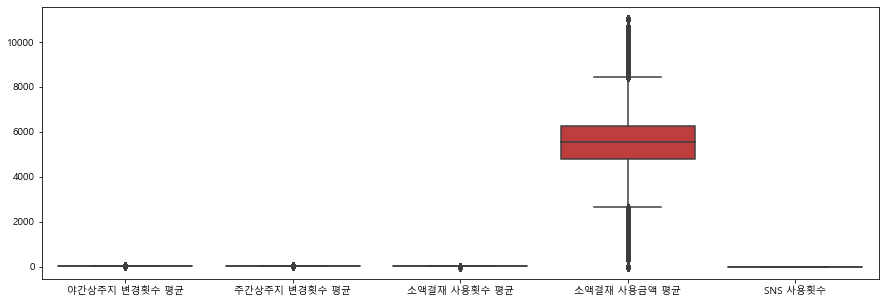

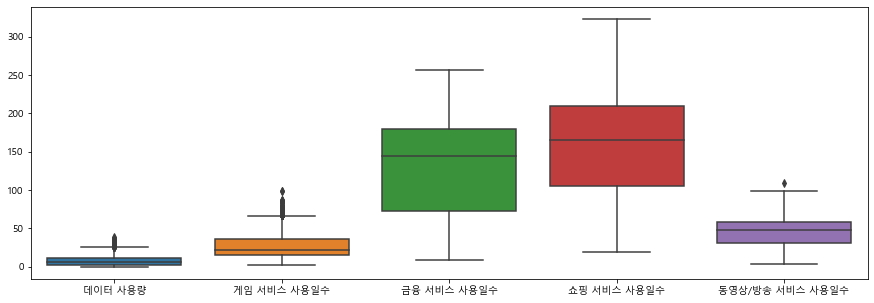

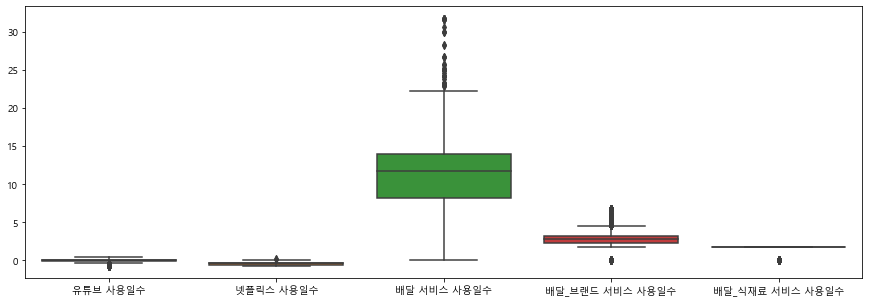

In [12]:
# 아웃라이어 확인 박스플롯
def make_box(data):
    for i in range(3):
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=data.iloc[:, i*5:(i+1)*5])
        plt.show()

make_box(alter_data_clean)

In [13]:
# 아웃라이어 제거
def remove_outliers(df):
    df_out = df.iloc[:,:15]
    Q1 = df_out.quantile(0.25)
    Q3 = df_out.quantile(0.75)
    IQR = Q3 - Q1
    filter =  ~((df_out < (Q1 - 1.5 * IQR)) | (df_out > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[filter]

alter_out = remove_outliers(alter_data_clean)

alter_out.shape

(34819, 24)

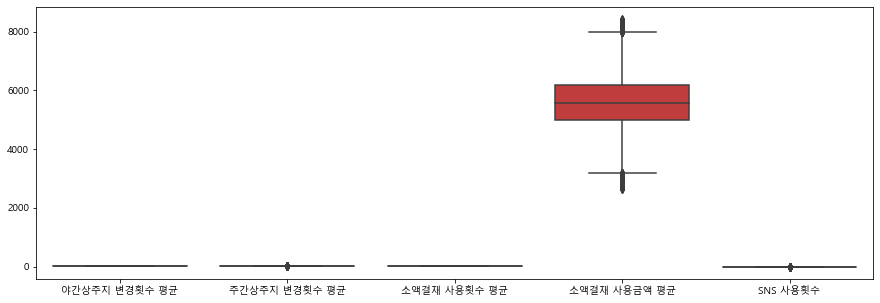

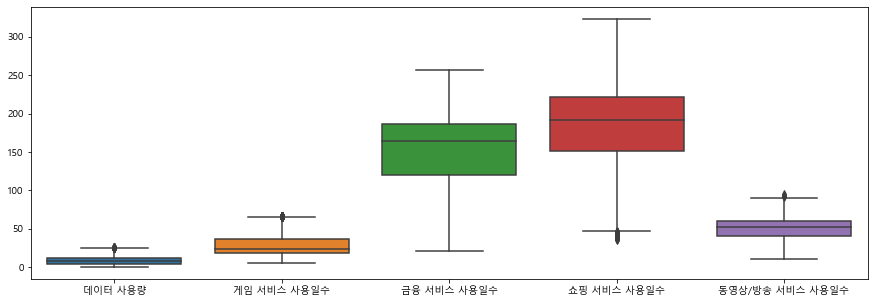

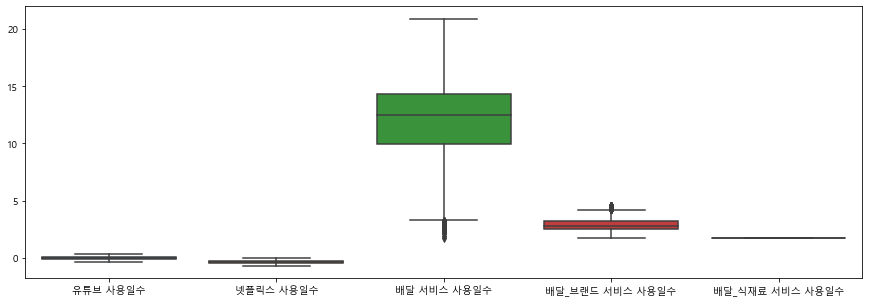

In [14]:
# 아웃라이어 제거 확인
make_box(alter_out)

In [15]:
# 모델학습 핵심 지표 매핑
alter_mapping = {
    '소비 빈도 및 활동성': [
        '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '소액결재 사용횟수 평균', 
        'SNS 사용횟수', '게임 서비스 사용일수', '쇼핑 서비스 사용일수'
    ],
    '소비 금액 및 규모': [
        '소액결재 사용금액 평균', '데이터 사용량', '유튜브 사용일수', 
        '넷플릭스 사용일수', '배달 서비스 사용일수'
    ],
    '서비스 이용 다양성': [
        '금융 서비스 사용일수', '동영상/방송 서비스 사용일수', 
        '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수'
    ]
}

In [16]:
# 정규화(X)
# 핵심 지표 생성 함수
def create_core_features(data, mapping):
    core_features = {}
    for feature_name, columns in mapping.items():
        core_features[feature_name] = data[columns].mean(axis=1)  # 평균값으로 통합
    return pd.DataFrame(core_features)

alter_index = create_core_features(alter_out, alter_mapping)
alter_notnorm = pd.concat([alter_index, alter_out.iloc[:,15:]], axis=1)

display(alter_notnorm.head())

,소비 빈도 및 활동성,소비 금액 및 규모,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
1,37.150000,1562.24,62.100,1,0,1,0,0,0,0,0,1
2,37.016667,1176.98,62.450,1,0,0,1,0,0,0,0,1
3,38.066667,1262.78,61.125,1,0,0,1,0,0,0,0,1
4,38.000000,1224.64,62.425,1,0,0,0,1,0,0,0,0
5,35.066667,1090.60,56.775,1,0,0,0,1,0,0,0,0


In [17]:
# 정규화 O
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mscaler = MinMaxScaler()

def create_core_features(data, mapping, scaler):
    core_features = {}
    
    for feature_name, columns in mapping.items():
        # 해당 그룹의 컬럼들 정규화
        scaled_values = scaler.fit_transform(data[columns])
        # 정규화된 값들의 평균 계산
        core_features[feature_name] = np.mean(scaled_values, axis=1)
    
    return pd.DataFrame(core_features)

# 정규화
alter_mm = create_core_features(alter_out, alter_mapping, mscaler).reset_index(drop=True)
alter_reindex = alter_out.reset_index(drop=True)

# 결합 시도
alter_minmax = pd.concat([alter_mm, alter_reindex.iloc[:,15:]], axis=1)

# 결과 확인
display(alter_minmax.head())

,소비 빈도 및 활동성,소비 금액 및 규모,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.641394,0.768399,0.409465,1,0,1,0,0,0,0,0,1
1,0.586476,0.652896,0.454870,1,0,0,1,0,0,0,0,1
2,0.460871,0.612550,0.438317,1,0,0,1,0,0,0,0,1
3,0.497903,0.563611,0.426953,1,0,0,0,1,0,0,0,0
4,0.515722,0.523879,0.420061,1,0,0,0,1,0,0,0,0


In [18]:
# 대안 데이터
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def data_split(data):
    x = data.drop(columns=['연체여부'])
    y = data['연체여부']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = data_split(alter_minmax)

In [19]:
# 신용카드 데이터
credit_data = pd.read_csv('../alternative_data/credit(120만).csv')
credit_data.rename(columns={'회원여부_연체':'연체여부'}, inplace=True)
credit_data = credit_data.drop(['연체 가능성 및 신용 리스크'], axis=1)
credit_data.head()

,소비 빈도 및 활동성,소비 금액 및 규모,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.384426,0.077502,0.25,0,1,0,0,1,0,0,0,1
1,0.265004,0.042410,0.25,0,1,1,0,0,0,0,0,1
2,0.076045,0.038398,0.25,0,1,0,0,0,1,0,0,1
3,0.119652,0.045946,0.25,0,1,0,1,0,0,0,0,1
4,0.168577,0.040089,0.25,1,0,0,0,0,0,1,0,1


In [20]:
x_test_p = credit_data.drop(['연체여부'], axis=1)
y_test_p = credit_data['연체여부']
print(x_test_p.shape, y_test_p.shape)

(1200000, 11) (1200000,)


In [21]:
# XGBoost 모델 생성
def xgb_grid_model(x_train, x_val, y_train, y_val):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7], 
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # XGBClassifier 초기화
    xgb_model = XGBClassifier(objective='binary:logistic', 
                            random_state=42,
                            scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

    # GridSearchCV 초기화
    grid_search = GridSearchCV(estimator=xgb_model, 
                            param_grid=param_grid, 
                            scoring='precision', 
                            cv=3)

    # GridSearchCV 실행
    grid_search.fit(x_train, y_train)

    # 최적의 하이퍼파라미터 출력
    print("최적의 하이퍼파라미터:", grid_search.best_params_)
    print("최적의 precision 점수:", grid_search.best_score_)

    # 최적의 하이퍼파라미터로 모델 재훈련
    best_xgb_model = grid_search.best_estimator_
    best_xgb_model.fit(x_train, y_train, 
                       eval_set=[(x_val, y_val)])
    
    return best_xgb_model
    
best_xgb_model = xgb_grid_model(x_train, x_val, y_train, y_val)

최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
최적의 precision 점수: 0.7272035925479524
[0]	validation_0-logloss:0.69085
[1]	validation_0-logloss:0.68869
[2]	validation_0-logloss:0.68653
[3]	validation_0-logloss:0.68438
[4]	validation_0-logloss:0.68230
[5]	validation_0-logloss:0.68019
[6]	validation_0-logloss:0.67823
[7]	validation_0-logloss:0.67623
[8]	validation_0-logloss:0.67433
[9]	validation_0-logloss:0.67241
[10]	validation_0-logloss:0.67053
[11]	validation_0-logloss:0.66873
[12]	validation_0-logloss:0.66699
[13]	validation_0-logloss:0.66524
[14]	validation_0-logloss:0.66351
[15]	validation_0-logloss:0.66179
[16]	validation_0-logloss:0.66006
[17]	validation_0-logloss:0.65834
[18]	validation_0-logloss:0.65670
[19]	validation_0-logloss:0.65503
[20]	validation_0-logloss:0.65343
[21]	validation_0-logloss:0.65190
[22]	validation_0-logloss:0.65037
[23]	validation_0-logloss:0.64887
[24]	validation_0

In [22]:
#  평가 함수
def evaluate_model(model, x_val, y_val):
    y_pred = model.predict(x_val)
    y_pred_proba = model.predict_proba(x_val)

    print('Accuracy:', accuracy_score(y_val, y_pred))
    print('Precision:', precision_score(y_val, y_pred))
    print('Recall:', recall_score(y_val, y_pred))
    print('F1-score:', f1_score(y_val, y_pred))
    print('ROC AUC:', roc_auc_score(y_val, y_pred_proba[:, 1]))

    # 피쳐 중요도
    feature_importance = pd.DataFrame({
        'feature': x_val.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(8, 5))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.xticks(rotation=45)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    # 혼동행렬 생성
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, 
                fmt='d', 
                cmap='Blues', 
                xticklabels=['0', '1'], 
                yticklabels=['0', '1'], 
                annot=True, annot_kws={"size": 20})
    plt.xlabel('예측')
    plt.ylabel('실제')
    plt.title('Confusion Matrix')
    plt.show()
  
    return y_pred, y_pred_proba

Accuracy: 0.7143882825962091
Precision: 0.7223140495867768
Recall: 0.7277268942547876
F1-score: 0.725010369141435
ROC AUC: 0.7926833014538861


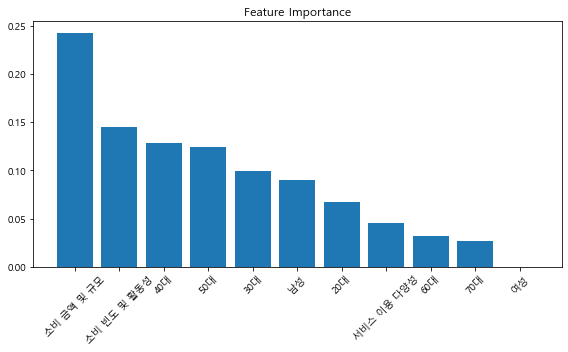

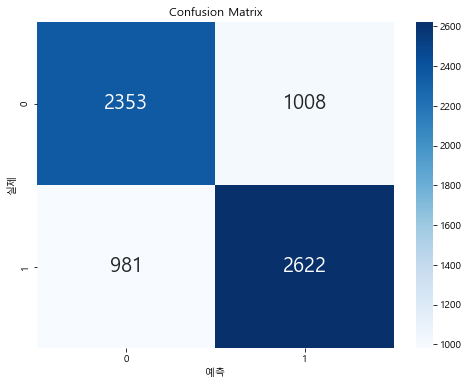

In [23]:
# XGB모델 대안 평가 예측
y_pred_alter_xgb, y_pred_proba_alter_xgb = evaluate_model(best_xgb_model, x_test, y_test)

Accuracy: 0.7423825
Precision: 0.05263157894736842
Recall: 6.47025140161821e-06
F1-score: 1.2938912160960069e-05
ROC AUC: 0.48404684849541507


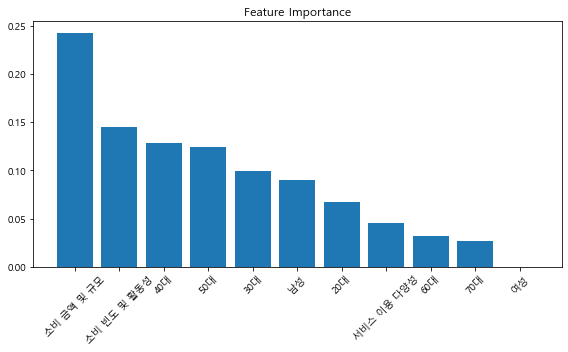

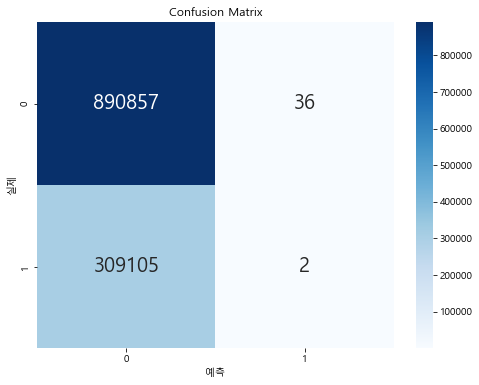

In [24]:
# XGB모델 신용카드 예측
y_pred_credit_xgb, y_pred_proba_credit_xgb = evaluate_model(best_xgb_model,  x_test_p, y_test_p)

In [25]:
# RandomForest 모델 설계
def rf_grid_model(x_train, y_train):
    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [ 10, 20, 30],
        'min_samples_split': [ 5, 10],
        'min_samples_leaf': [ 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    
    # 랜덤포레스트 모델 초기화
    rf_model = RandomForestClassifier(random_state=42)

    # GridSearchCV 초기화
    grid_search_rf = GridSearchCV(estimator=rf_model, 
                                  param_grid=param_grid, 
                                  scoring='recall', 
                                  cv=3,
                                  n_jobs=-1)  # 병렬 처리 활성화
    
    # GridSearchCV 실행
    grid_search_rf.fit(x_train, y_train)

    # 최적의 하이퍼파라미터 출력
    print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
    print("최적의 AUC 점수:", grid_search_rf.best_score_)

    # 최적의 하이퍼파라미터로 모델 재훈련
    best_rf_model = grid_search_rf.best_estimator_
    best_rf_model.fit(x_train, y_train)
    
    
    return best_rf_model

best_rf_model = rf_grid_model(x_train, y_train)

최적의 하이퍼파라미터: {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
최적의 AUC 점수: 0.7626689189929384


Accuracy: 0.7086444572085009
Precision: 0.6964553170244633
Recall: 0.7743547044129891
F1-score: 0.733342094887633
ROC AUC: 0.7920112359671182


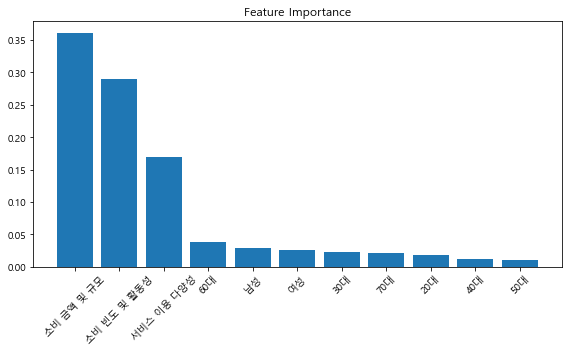

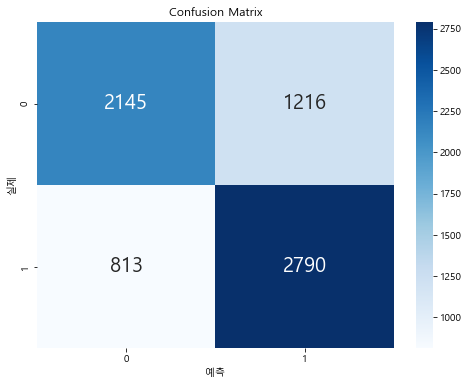

In [26]:
# 랜덤포레스트 모델 대안 평가 예측
y_pred_rf, y_pred_proba_rf = evaluate_model(best_rf_model, x_test, y_test)

Accuracy: 0.739205
Precision: 0.10832824272042355
Recall: 0.001721086872830444
F1-score: 0.0033883407957505623
ROC AUC: 0.4252239026640877


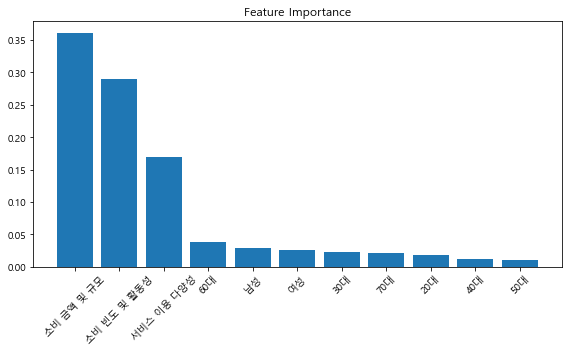

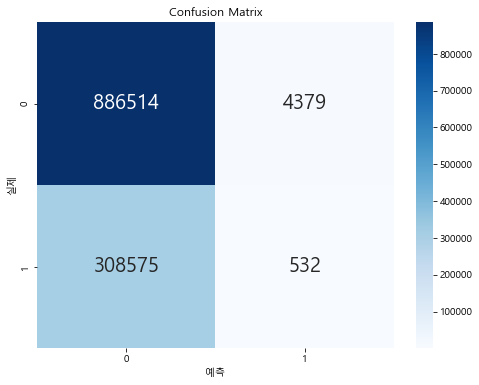

In [27]:
# 랜덤포레스트 모델 신용카드 예측
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(best_rf_model, x_test_p, y_test_p)

성별, 나이대 제거

In [28]:
# 대안신용평가 데이터
x_train_alter = x_train.iloc[:,:3]
x_val_alter = x_val.iloc[:,:3]
x_test_alter = x_test.iloc[:,:3]

display(x_train_alter.head())
display(x_val_alter.head())
display(x_test_alter.head())

,소비 빈도 및 활동성,소비 금액 및 규모,서비스 이용 다양성
19104,0.216078,0.242746,0.235463
18524,0.506218,0.518329,0.396824
30604,0.448554,0.362344,0.311217
21510,0.561556,0.665496,0.481247
31967,0.517960,0.483681,0.442345


,소비 빈도 및 활동성,소비 금액 및 규모,서비스 이용 다양성
3897,0.372325,0.459634,0.291483
22886,0.308125,0.235247,0.121614
5720,0.276053,0.346781,0.339642
30064,0.625475,0.556437,0.424905
10031,0.352083,0.343195,0.350317


,소비 빈도 및 활동성,소비 금액 및 규모,서비스 이용 다양성
33413,0.410004,0.414829,0.225012
10274,0.465612,0.497636,0.354404
25305,0.424495,0.316860,0.320244
21235,0.396235,0.258734,0.275952
9153,0.314597,0.291631,0.271305


In [29]:
# 신용카드 이용 데이터
x_test_credit = x_test_p.iloc[:,:3]
display(x_test_credit.head())

,소비 빈도 및 활동성,소비 금액 및 규모,서비스 이용 다양성
0,0.384426,0.077502,0.25
1,0.265004,0.042410,0.25
2,0.076045,0.038398,0.25
3,0.119652,0.045946,0.25
4,0.168577,0.040089,0.25


xgb

In [30]:
# 인구통계 제거 xgb
xgb_alter_model = xgb_grid_model(x_train_alter, x_val_alter, y_train, y_val)

최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
최적의 precision 점수: 0.6981941187839484
[0]	validation_0-logloss:0.64766
[1]	validation_0-logloss:0.62295
[2]	validation_0-logloss:0.60729
[3]	validation_0-logloss:0.59827
[4]	validation_0-logloss:0.59242
[5]	validation_0-logloss:0.58874
[6]	validation_0-logloss:0.58646
[7]	validation_0-logloss:0.58501
[8]	validation_0-logloss:0.58385
[9]	validation_0-logloss:0.58306
[10]	validation_0-logloss:0.58266
[11]	validation_0-logloss:0.58237
[12]	validation_0-logloss:0.58219
[13]	validation_0-logloss:0.58156
[14]	validation_0-logloss:0.58107
[15]	validation_0-logloss:0.58069
[16]	validation_0-logloss:0.58047
[17]	validation_0-logloss:0.58035
[18]	validation_0-logloss:0.58036
[19]	validation_0-logloss:0.58039
[20]	validation_0-logloss:0.58035
[21]	validation_0-logloss:0.57998
[22]	validation_0-logloss:0.57994
[23]	validation_0-logloss:0.57978
[24]	validation_0-

Accuracy: 0.684233199310741
Precision: 0.6926454445664105
Recall: 0.7005273383291701
F1-score: 0.6965640954877881
ROC AUC: 0.7577056723945622


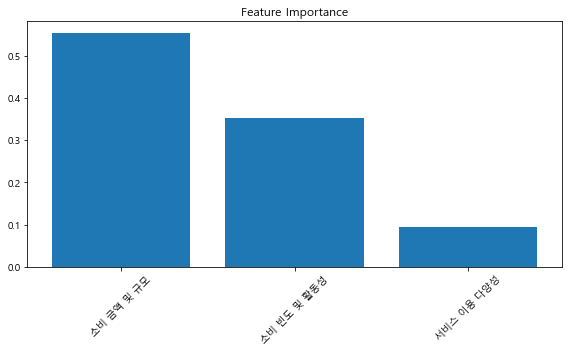

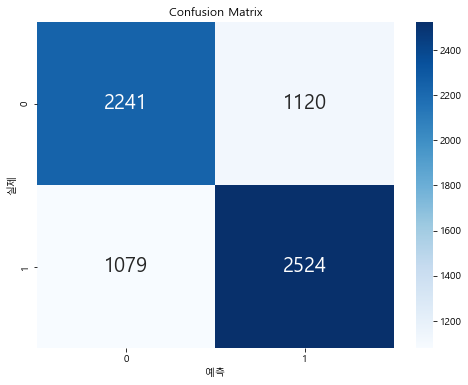

In [32]:
# xgb 대안 평가 데이터
y_pred_xgb_alter, y_pred_proba_xgb_alter = evaluate_model(xgb_alter_model,  x_test_alter, y_test)

Accuracy: 0.7421458333333333
Precision: 0.03508771929824561
Recall: 3.882150840970926e-05
F1-score: 7.75572065186832e-05
ROC AUC: 0.5513016217484427


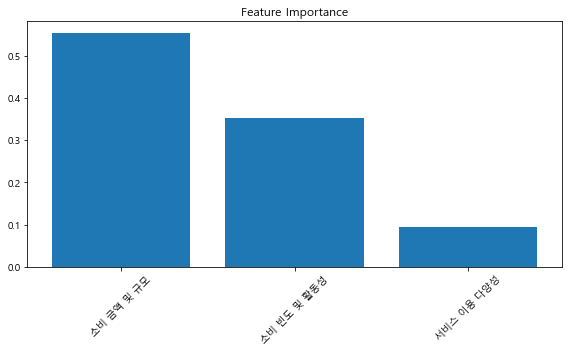

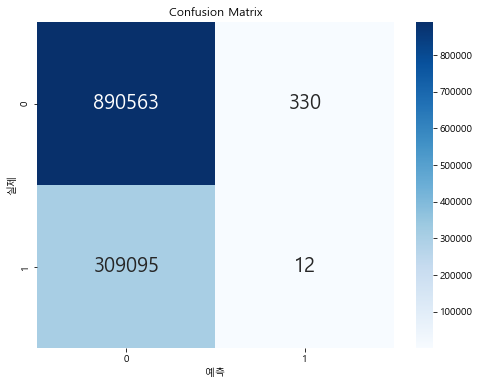

In [33]:
# xgb 신용카드 데이터
y_pred_xgb_credit, y_pred_proba_xgb_credit = evaluate_model(xgb_alter_model,  x_test_credit, y_test_p)

rf모델

In [35]:
# rf모델
rf_alter_model = rf_grid_model(x_train_alter, y_train)

최적의 하이퍼파라미터: {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
최적의 AUC 점수: 0.74831193842473


Accuracy: 0.6802125215393452
Precision: 0.6680508060576453
Recall: 0.759089647515959
F1-score: 0.7106664934390022
ROC AUC: 0.7554317482959712


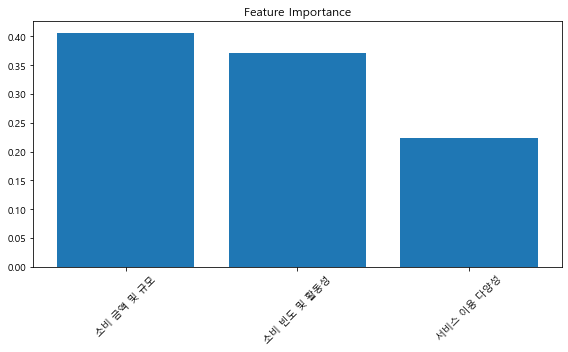

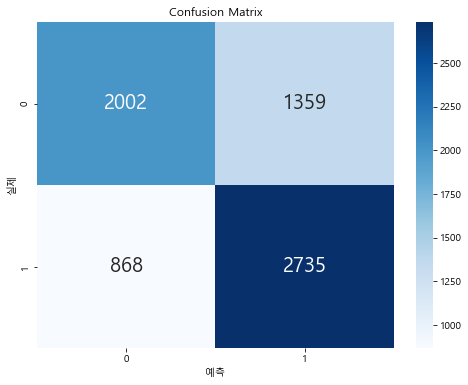

In [36]:
# val 데이터 결과
y_pred_rf_alter, y_pred_proba_rf_alter = evaluate_model(rf_alter_model,  x_test_alter, y_test)

Accuracy: 0.7423533333333333
Precision: 0.0273972602739726
Recall: 6.47025140161821e-06
F1-score: 1.293744744161977e-05
ROC AUC: 0.4419536965680821


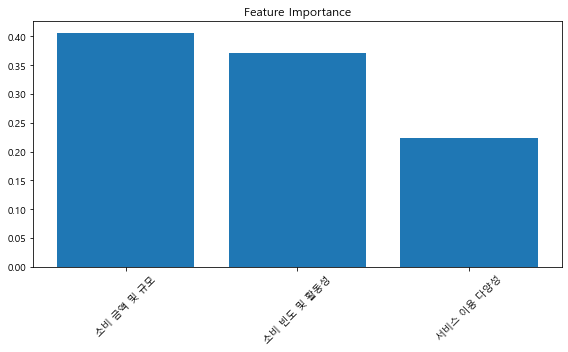

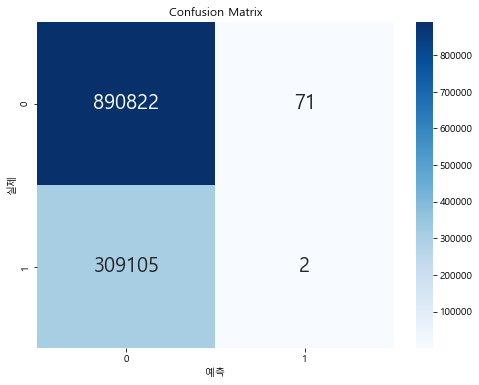

In [37]:
# test 데이터 결과
y_pred_rf_credit, y_pred_proba_rf_credit = evaluate_model(rf_alter_model,  x_test_credit, y_test_p)

In [42]:
alternative_cls = {
    "서비스 이용 빈도": [
        "데이터 사용량",
        "동영상/방송 서비스 사용일수",
        "게임 서비스 사용일수",
        "SNS 사용횟수",
        "배달 서비스 사용일수",
        "유튜브 사용일수",
        "금융 서비스 사용일수"
    ],
    "카드 보유 및 사용 정보": [
        "금융 서비스 사용일수"
    ]
}

# credit_cls = {
#     "카드 보유 및 사용 정보": [
#         "소지여부_신용",
#         "유효카드수_신용",
#         "유효카드수_체크",
#         "이용가능카드수_신용",
#         "이용가능카드수_체크",
#         "이용카드수_신용",
#         "이용거절여부_카드론"
#     ],
#     "서비스 이용 빈도": [
#         "이용금액_R3M_신용",
#         "이용금액_R3M_체크",
#         "이용건수_R3M",
#         "청구금액_B0"
#     ]
# }

### 상관관계 있는 칼럼

In [43]:
alter_cls = create_core_features(alter_out, alternative_cls, mscaler).reset_index(drop=True)
alter_reindex = alter_out.reset_index(drop=True)

# 결합 시도
alter_minmax_cls = pd.concat([alter_cls, alter_reindex.iloc[:,15:]], axis=1)

# 결과 확인
display(alter_minmax_cls.head())

,서비스 이용 빈도,카드 보유 및 사용 정보,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.700691,0.708651,1,0,1,0,0,0,0,0,1
1,0.669635,0.712892,1,0,0,1,0,0,0,0,1
2,0.600108,0.695505,1,0,0,1,0,0,0,0,1
3,0.548711,0.716709,1,0,0,0,1,0,0,0,0
4,0.534758,0.621289,1,0,0,0,1,0,0,0,0


In [62]:
credit_minmax_cls = pd.read_csv('../alternative_data/corr_credit.csv')
credit_minmax_cls.rename(columns={'회원여부_연체':'연체여부'}, inplace=True)

x_test_p = credit_minmax_cls.drop(['연체여부'],axis=1)
x_test_p.insert(0, "서비스 이용 빈도", x_test_p.pop("서비스 이용 빈도"))
y_test_p = credit_minmax_cls['연체여부']

credit_minmax_cls.head()

In [50]:
# corr
x_train, x_val, x_test, y_train, y_val, y_test = data_split(alter_minmax_cls)
xgb_corr_model = xgb_grid_model(x_train,x_val,y_train,y_val)

최적의 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
최적의 precision 점수: 0.7634010724124959
[0]	validation_0-logloss:0.66045
[1]	validation_0-logloss:0.64277
[2]	validation_0-logloss:0.62556
[3]	validation_0-logloss:0.61460
[4]	validation_0-logloss:0.60070
[5]	validation_0-logloss:0.59395
[6]	validation_0-logloss:0.58610
[7]	validation_0-logloss:0.57908
[8]	validation_0-logloss:0.57360
[9]	validation_0-logloss:0.57230
[10]	validation_0-logloss:0.57049
[11]	validation_0-logloss:0.56562
[12]	validation_0-logloss:0.56235
[13]	validation_0-logloss:0.56040
[14]	validation_0-logloss:0.55802
[15]	validation_0-logloss:0.55309
[16]	validation_0-logloss:0.55213
[17]	validation_0-logloss:0.55136
[18]	validation_0-logloss:0.54776
[19]	validation_0-logloss:0.54580
[20]	validation_0-logloss:0.54300
[21]	validation_0-logloss:0.54161
[22]	validation_0-logloss:0.54086
[23]	validation_0-logloss:0.53999
[24]	validation_0-

Accuracy: 0.7454049396898335
Precision: 0.7513736263736264
Recall: 0.759089647515959
F1-score: 0.7552119287588017
ROC AUC: 0.8256084407824713


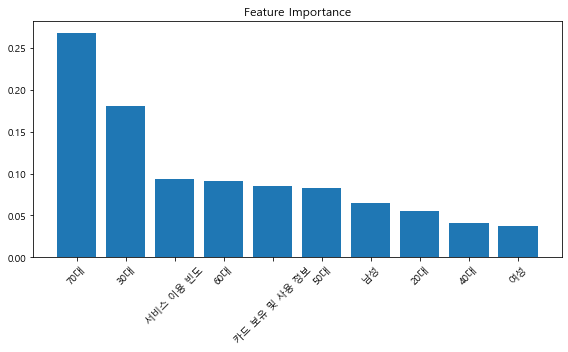

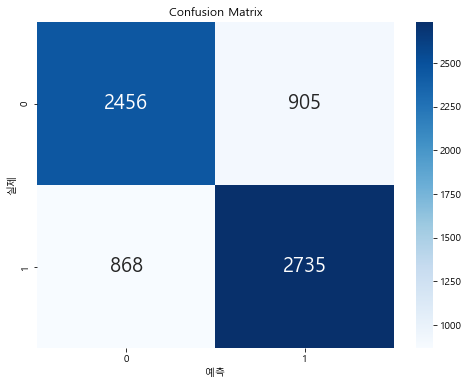

(array([0, 0, 0, ..., 1, 0, 1]),
 array([[0.54287374, 0.45712626],
        [0.82406956, 0.17593043],
        [0.82427406, 0.17572595],
        ...,
        [0.20688105, 0.79311895],
        [0.9482731 , 0.05172689],
        [0.24355787, 0.7564421 ]], dtype=float32))

In [51]:
evaluate_model(xgb_corr_model, x_test, y_test)

Accuracy: 0.7359633333333333
Precision: 0.16074717179689554
Recall: 0.005929985409583089
F1-score: 0.01143802065458176
ROC AUC: 0.4897676716240701


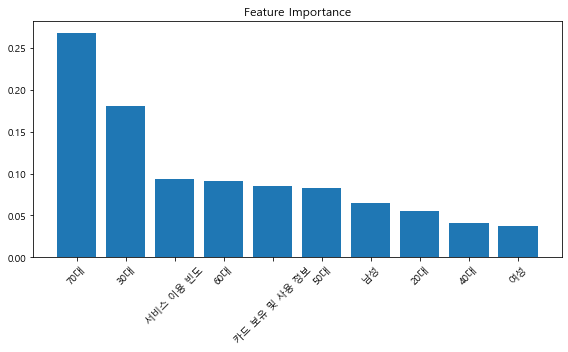

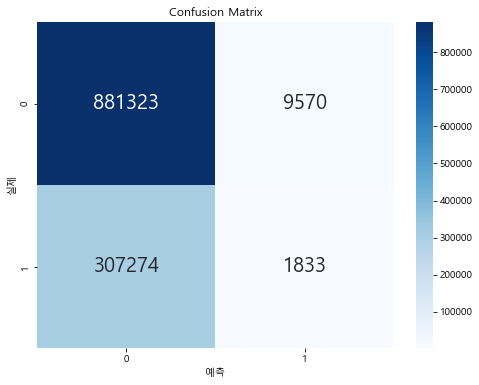

(array([0, 0, 0, ..., 0, 0, 0]),
 array([[9.9957651e-01, 4.2349135e-04],
        [9.9848914e-01, 1.5108817e-03],
        [8.1118441e-01, 1.8881558e-01],
        ...,
        [9.6600187e-01, 3.3998132e-02],
        [9.8567659e-01, 1.4323405e-02],
        [9.5402831e-01, 4.5971710e-02]], dtype=float32))

In [65]:
evaluate_model(xgb_corr_model, x_test_p, y_test_p)

In [67]:
rf_corr_model = rf_grid_model(x_train,y_train)

최적의 하이퍼파라미터: {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
최적의 AUC 점수: 0.8076235985951444


Accuracy: 0.7383687535898908
Precision: 0.7250442254233005
Recall: 0.7962808770469053
F1-score: 0.758994708994709
ROC AUC: 0.8173415026636123


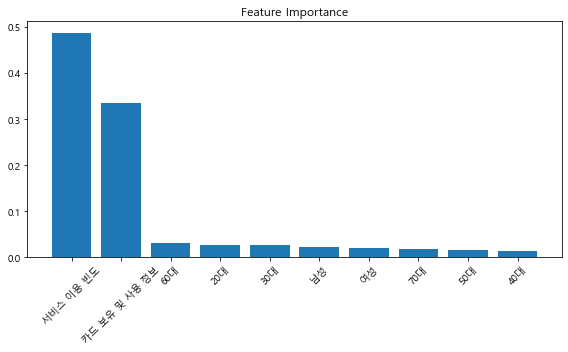

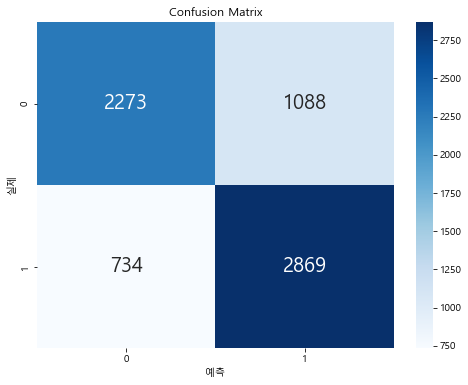

(array([0, 0, 0, ..., 1, 0, 1], dtype=int64),
 array([[0.56387149, 0.43612851],
        [0.74468458, 0.25531542],
        [0.83811444, 0.16188556],
        ...,
        [0.16962852, 0.83037148],
        [0.9537651 , 0.0462349 ],
        [0.236036  , 0.763964  ]]))

In [68]:
evaluate_model(rf_corr_model, x_test, y_test)

Accuracy: 0.72977
Precision: 0.15286740811936472
Recall: 0.010805319840702411
F1-score: 0.02018395194527369
ROC AUC: 0.48169825894902124


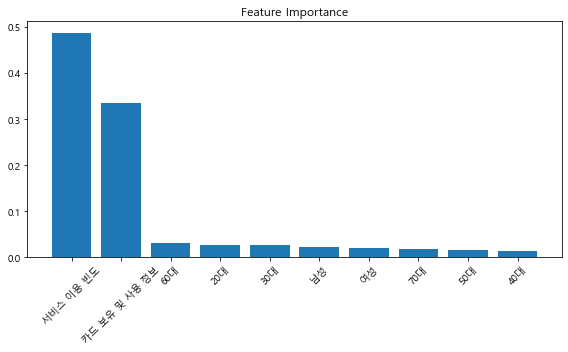

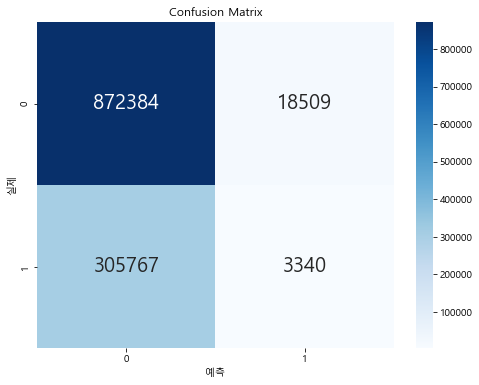

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([[0.86460945, 0.13539055],
        [0.76416818, 0.23583182],
        [0.6218076 , 0.3781924 ],
        ...,
        [0.77213307, 0.22786693],
        [0.82355201, 0.17644799],
        [0.72499633, 0.27500367]]))

In [69]:
evaluate_model(rf_corr_model, x_test_p, y_test_p)